<a href="https://colab.research.google.com/github/RPTS/Aneurysm_2020_Code/blob/main/hollister_project_version_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install tensorflow-text
!pip install -q tf-models-official

     |████████████████████████████████| 4.9 MB 7.4 MB/s 
     |████████████████████████████████| 1.8 MB 8.4 MB/s 
     |████████████████████████████████| 596 kB 37.5 MB/s 
     |████████████████████████████████| 213 kB 55.6 MB/s 
     |████████████████████████████████| 352 kB 20.7 MB/s 
     |████████████████████████████████| 1.2 MB 72.0 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 
     |████████████████████████████████| 99 kB 9.9 MB/s 
     |████████████████████████████████| 90 kB 10.7 MB/s 
     |████████████████████████████████| 47.6 MB 1.3 MB/s 
     |████████████████████████████████| 1.1 MB 58.4 MB/s 


In [ ]:
import tensorflow as tf
import tensorflow_text as text

In [ ]:
import pandas as pd
import re
import nltk
from nltk.stem.porter import *
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
import gensim
from gensim.models import Word2Vec
from nltk import word_tokenize
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_recall_fscore_support
from statistics import mean
from numpy import array
from numpy import asarray
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from numpy import zeros
from keras.layers import Embedding
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow import keras
import tensorflow_hub as hub
#from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Import data

There are four features we can extract from the table below: title, lens, summary and linkref. In the first trial we will only use title and summary for text classification.

In [ ]:
df = pd.read_excel('drive/MyDrive/Hollister Confidential-Futurism 2021 - DeDuplication Tool v01c (1).xlsx', sheet_name='Clues')
df.head()

,id,title,Lens,summaryplaintext,linkRef
0,2772,CC project for futurism started,Political,Futurism gaining interest within the organizat...,Reference:&nbsp;check FEI records
1,2773,DELETE ME Great eagerness tp participate from...,Societal,opt-in participation is not meant to stress pe...,NaN
2,2774,"this is what I heard the customer say, ""La di ...",Environmental,I think they meant that ehy wanted something t...,<div>hyperlink 1</div><div>'KEEP THIS AREA BRI...
3,2789,"Reducitarian Kateman: ""Technological innovatio...",Economical,There is growing awareness that sustainability...,"<p><a href=""https://www.fastcompany.com/905995..."
4,2790,Medical Futurist Meskó broadly covers wearable...,Social,Message is that healthcare is still trying to ...,<div>1. https://open.spotify.com/episode/4OtPk...


# Preprocess title + summary text

In [ ]:
# Concat title and summary plain text
df['full_text'] = df['title'] + ' ' + df['summaryplaintext']

### remove non algebra characters

In [ ]:
# Convert to lowercase
full_text_ls = [df['full_text'][i].lower() for i in range(len(df['full_text']))]

# Remove numbers / punctuation / special characters
full_text_ls = [re.sub('[^A-Za-z]+', ' ', i) for i in full_text_ls]

full_text_ls = [re.sub('cannot', 'can not', i) for i in full_text_ls]
full_text_ls = [re.sub(' the ', ' ', i) for i in full_text_ls]
full_text_ls = [re.sub(' a ', ' ', i) for i in full_text_ls]

# Strip white space
full_text_ls = [i.strip() for i in full_text_ls]

### conduct stemming

In [ ]:
stemmer = PorterStemmer()
stemmed_text = []
for string in full_text_ls:
  new_string = ' '.join(stemmer.stem(token) for token in nltk.word_tokenize(string))
  stemmed_text.append(new_string)

print(stemmed_text)


['cc project for futur start futur gain interest within organ delet thi clue after test', 'delet me great eager tp particip from respond opt in particip is not meant to stress peopl out but rather integr into their work selef select mental lead to inprov qualiti of output', 'thi is what i heard custom say la di da di i think they meant that ehi want someth thinnner not necessarili shorter', 'reducitarian kateman technolog innov ha role to play in advanc moral progress but so do ethic argument there is grow awar that sustain and climat chang will not be address without buy in of corpor strategi', 'medic futurist mesk broadli cover wearabl microbiom and ai in recent podcast messag is that healthcar is still tri to figur out what to do with insight provid by tidal wave of data that is readili avail to patient consum believ that cultur transform in healthcar is need befor wearabl data becom usabl', 'darpa award m in contract to alter microbiom to repel mosquito govern back new use case for

In [ ]:
df['cleaned_text'] = full_text_ls
df['stemmed_text'] = stemmed_text

### create dependent variable

In [ ]:
# load hunch data and count clue frequency
hunch = pd.read_excel('drive/MyDrive/Hollister Confidential-Futurism 2021 - DeDuplication Tool v01c (1).xlsx', sheet_name='Hunches')
hunch[['Clue1', 'Clue2','Clue3', 'Clue4','Clue5']] = hunch[['Clue1', 'Clue2','Clue3', 'Clue4','Clue5']].fillna(0).astype(int)
all_clue = pd.concat([hunch['Clue1'],hunch['Clue2'], hunch['Clue3'], hunch['Clue4'], hunch['Clue5']], ignore_index=True)
clue_frequency = all_clue.value_counts()

In [ ]:
del clue_frequency[0]
clue_frequency = pd.DataFrame(clue_frequency, columns= ['frequency'])
clue_frequency['id'] = clue_frequency.index

In [ ]:
# fill un-used clue with 0
df = df.merge(clue_frequency, how = 'left', on = 'id')
df['frequency'] = df['frequency'].fillna(0).astype(int)

In [ ]:
pd.options.display.max_colwidth = 2000
# take a look at the most used clues
most_clue = df[['cleaned_text','frequency','Lens']][df['frequency'] >= 5]
most_clue

KeyError: ignored

In [ ]:
df['multi_frequency'] = df['frequency'].copy()
df['binary_frequency'] = np.where(df['frequency'] > 0, 1, 0)

In [ ]:
df['binary_frequency'].value_counts()

1    153
0     79
Name: binary_frequency, dtype: int64

In [ ]:
df.to_csv('hollister_cleaned.csv')
!cp hollister_cleaned.csv "drive/My Drive/hollister_nlp/"

### 

### train test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text'], df['binary_frequency'],
                                                    stratify=df['binary_frequency'], 
                                                    test_size=0.30, random_state = 0)

df_train = pd.concat([pd.DataFrame({'cleaned_text': X_train.values}),pd.DataFrame({'binary_frequency': y_train.values})], axis = 1)
df_test = pd.concat([pd.DataFrame({'cleaned_text': X_test.values}),pd.DataFrame({'binary_frequency': y_test.values})], axis = 1)
over_sample = df_train[df_train['binary_frequency'] == 0]

In [ ]:
df_train['binary_frequency'].value_counts()[0]

55

In [ ]:
# manually create 3-fold cross validation data
import random
for i in range(52):
  kk = random.randrange(54)
  row = over_sample.iloc[[kk]]
  df_train = df_train.append(row)

In [ ]:
df_train['binary_frequency'].value_counts()
X_train = df_train['cleaned_text']
y_train = df_train['binary_frequency']

In [ ]:
sum(df['cleaned_text'].str.split(expand=True).stack().value_counts() == 1)

2410

### text classification

Here we try out three methods for the bi-frequency output:    
1. Bag of words
2. Word2vec
3. BERT/XLNet/RoBERTa

1. Bag of words

In [ ]:
def bow_model(x_train, x_test, y_train, y_test, n1, n2, analyzer = 'word', norm = 'l2',cutoff = 0.5, use_idf=True, model = 'MultinomialNB', multi_class = False):
  count_vec = CountVectorizer(ngram_range=(n1, n2), stop_words='english', analyzer= analyzer)
  bow_count = count_vec.fit_transform(x_train)
  tf_transformer = TfidfTransformer(norm = norm, use_idf = use_idf).fit(bow_count)
  bow = tf_transformer.transform(bow_count)
  
  if model == 'MultinomialNB' and multi_class == False:
    clf = MultinomialNB().fit(bow, y_train)
    X_new_counts = count_vec.transform(x_test)
    X_new_tfidf = tf_transformer.transform(X_new_counts)
    confidence = clf.predict_proba(X_new_tfidf)
    predicted = [item[0] for item in np.where(confidence>cutoff,0,1)]
    #return y_test, predicted, confidence

  if model == 'LogisticRegression' and multi_class == False:
    clf = LogisticRegression().fit(bow, y_train)
    X_new_counts = count_vec.transform(x_test)
    X_new_tfidf = tf_transformer.transform(X_new_counts)
    confidence = clf.predict_proba(X_new_tfidf)
    predicted = [item[0] for item in np.where(confidence>cutoff,0,1)]
   # return y_test, predicted, confidence

  if model == 'SGDClassifier' and multi_class == False:
    clf = SGDClassifier(loss='modified_huber', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None).fit(bow, y_train)
    X_new_counts = count_vec.transform(x_test)
    X_new_tfidf = tf_transformer.transform(X_new_counts)
    confidence = clf.predict_proba(X_new_tfidf)
    predicted = clf.predict(X_new_tfidf)
  #  return y_test, predicted, confidence

  micro_precision, micro_recall, micro_f1, support1 = precision_recall_fscore_support(y_test, predicted, average='micro')
  macro_precision, macro_recall, macro_f1, support2 = precision_recall_fscore_support(y_test, predicted, average='macro')

  return micro_precision, macro_precision, micro_recall, macro_recall, micro_f1, macro_f1, predicted, confidence

In [ ]:
bow_summary_table = pd.DataFrame(index=['model', 'norm', 'analyzer', 'ngram1', 'ngram2', 'micro_precision', 'macro_precision', 'micro_recall', 'macro_recall', 'micro_f1', 'macro_f1'])
i = 0
#prediction example
for n2 in (1,2):
  for analyzer in ['word', 'char']:
    for norm in ['l1', 'l2']:
      for model in ['MultinomialNB', 'LogisticRegression', 'SGDClassifier']:
        i = i + 1
        model_name = 'model' + str(i)
        micro_precision, macro_precision, micro_recall, macro_recall, micro_f1, macro_f1, predicted, confidence = bow_model(X_train, X_test, y_train, y_test, model = model, n1 = 1, n2 = n2, analyzer = analyzer, norm = norm, cutoff = 0.33)
        bow_summary_table[model_name] = [model, norm, analyzer, '1', n2,micro_precision, macro_precision, micro_recall, macro_recall, micro_f1, macro_f1]

    #   micro_precision2, macro_precision2, micro_recall2, macro_recall2, micro_f12, macro_f12, predicted, confidence = bow_model(X_train2, X_test2, Y_train2, Y_test2, model = model, n1 = 1, n2 = n2, analyzer = analyzer, norm = norm, cutoff = 0.33)
      #  micro_precision3, macro_precision3, micro_recall3, macro_recall3, micro_f13, macro_f13, predicted, confidence = bow_model(X_train1, X_test1, Y_train1, Y_test1, model = model, n1 = 1, n2 = n2, analyzer = analyzer, norm = norm, cutoff = 0.33)
       
     # bow_summary_table[model_name] = [model, norm, analyzer, '1', n2,(micro_precision1+micro_precision2+micro_precision3)/3, (macro_precision1+macro_precision2+macro_precision3)/3, (micro_recall1+micro_recall2+micro_recall3)/3 , (macro_recall1+macro_recall2+macro_recall3)/3, (micro_f11+micro_f12+micro_f13)/3 , (macro_f11+macro_f12+macro_f13)/3]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

In [ ]:
bow_summary_table[['model9', 'model24']]
#micro_precision24, macro_precision24, micro_recall24, macro_recall24, micro_f124, macro_f124, predicted24, confidence24 = bow_model(X_train, X_test, y_train, y_test, 1,2, analyzer = 'char', norm = 'l2')

,model9,model24
model,SGDClassifier,SGDClassifier
norm,l1,l2
analyzer,char,char
ngram1,1,1
ngram2,1,2
micro_precision,0.657143,0.657143
macro_precision,0.585938,0.328571
micro_recall,0.657143,0.657143
macro_recall,0.529891,0.5
micro_f1,0.657143,0.657143


2. word embedding

In [ ]:
# all below are test codes

In [ ]:
def w2v_model(data, min_count, size, negative, iter, window, sg):
  df_tokenize = []
  for text in data:
    tokenized = word_tokenize(text)
    df_tokenize.append(tokenized)
  
  model = gensim.models.Word2Vec(sentences = df_tokenize, min_count = min_count, size = size, negative = negative, iter = iter, window = window, sg = sg)
  model.wv.save_word2vec_format('trial.txt', binary=False)
  return model

# word2vec trial1
w2v1 = w2v_model(X_train, 1, 100, 5, 5, 5, 0)

kk = w2v1.wv.vocab.keys()
kk = set(kk)

In [ ]:
def get_weight_matrix(embedding, vocab):
	# total vocabulary size plus 0 for unknown words
	vocab_size = len(vocab) + 1
	# define weight matrix dimensions with all 0
	weight_matrix = zeros((vocab_size, 100))
	# step vocab, store vectors using the Tokenizer's integer mapping
	for word, i in vocab.items():
		weight_matrix[i] = embedding.get(word)
	return weight_matrix

In [ ]:
# load embedding as a dict
def load_embedding(filename):
	# load embedding into memory, skip first line
	file = open(filename,'r')
	lines = file.readlines()[1:]
	file.close()
	# create a map of words to vectors
	embedding = dict()
	for line in lines:
		parts = line.split()
		# key is string word, value is numpy array for vector
		embedding[parts[0]] = asarray(parts[1:], dtype='float32')
	return embedding

In [ ]:
train_docs = X_train.tolist()

In [ ]:
# create the tokenizer
tokenizer = Tokenizer()
# fit the tokenizer on the documents
tokenizer.fit_on_texts(train_docs)
 
# sequence encode
encoded_docs = tokenizer.texts_to_sequences(train_docs)
# pad sequences
max_length = max([len(s.split()) for s in train_docs])

In [ ]:
Xtrain_array = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
# define training labels
ytrain_array = np.array(y_train.to_list())

In [ ]:
test_docs = X_test.to_list()
encoded_docs2 = tokenizer.texts_to_sequences(test_docs)
Xtest_array = pad_sequences(encoded_docs2, maxlen=max_length, padding='post')
Ytest_array = np.array(y_test.to_list())

In [ ]:
# define vocabulary size (largest integer value)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

3923

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
raw_embedding = load_embedding('trial.txt')

In [ ]:

# get vectors in the right order
embedding_vectors = get_weight_matrix(raw_embedding, tokenizer.word_index)
# create the embedding layer
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_vectors], input_length=max_length, trainable=False)

In [ ]:
list(tokenizer.word_index.keys())[1465:1468]

['fast', 'pharmacy', 'text']

In [ ]:
#######debug
array_sum = np.sum(embedding_vectors)
np.isnan(array_sum)

False

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.0001)

# define model
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
print(model.summary())
# compile network
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True), optimizer= opt, metrics=['accuracy'])
# fit network
model.fit(Xtrain_array, ytrain_array, epochs=10, batch_size=64, verbose=2)
# evaluate
loss, acc = model.evaluate(Xtest_array, Ytest_array, verbose=0)
preds = model.predict(Xtest_array)
print('Test Accuracy: %f' % (acc*100))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 353, 100)          392300    
                                                                 
 conv1d (Conv1D)             (None, 349, 32)           16032     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 174, 32)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5568)              0         
                                                                 
 dense (Dense)               (None, 1)                 5569      
                                                                 
Total params: 413,901
Trainable params: 21,601
Non-trainable params: 392,300
_____________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


4/4 - 1s - loss: 0.6964 - accuracy: 0.4953 - 1s/epoch - 319ms/step
Epoch 2/10
4/4 - 0s - loss: 0.6930 - accuracy: 0.5093 - 247ms/epoch - 62ms/step
Epoch 3/10
4/4 - 0s - loss: 0.6898 - accuracy: 0.5140 - 253ms/epoch - 63ms/step
Epoch 4/10
4/4 - 0s - loss: 0.6874 - accuracy: 0.5234 - 252ms/epoch - 63ms/step
Epoch 5/10
4/4 - 0s - loss: 0.6847 - accuracy: 0.5794 - 248ms/epoch - 62ms/step
Epoch 6/10
4/4 - 0s - loss: 0.6822 - accuracy: 0.5888 - 244ms/epoch - 61ms/step
Epoch 7/10
4/4 - 0s - loss: 0.6797 - accuracy: 0.6168 - 253ms/epoch - 63ms/step
Epoch 8/10
4/4 - 0s - loss: 0.6775 - accuracy: 0.6075 - 254ms/epoch - 63ms/step
Epoch 9/10
4/4 - 0s - loss: 0.6748 - accuracy: 0.6542 - 240ms/epoch - 60ms/step
Epoch 10/10
4/4 - 0s - loss: 0.6724 - accuracy: 0.6542 - 241ms/epoch - 60ms/step
Test Accuracy: 57.142860


In [ ]:
prediction_cnn = np.where(preds>0.5, 1, 0)
micro_precision2, micro_recall2, micro_f12, support12 = precision_recall_fscore_support(np.array(y_test), prediction_cnn, average='micro')
print(micro_precision2)
print(micro_recall2)
print(micro_f12)

0.5714285714285714
0.5714285714285714
0.5714285714285714


In [ ]:
prediction_cnn

array([[1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0]])

3. BERT


In [ ]:
df_train

,cleaned_text,binary_frequency
0,implantable bladder wrap for improved urinary control researchers at penn state have developed an implantable device that coils around bladder to detect when bladder is full and assist with emptying it by contracting on demand device is intended to treat underactive bladder condition in which incomplete bladder emptying leads to irregular and uncomfortable urination there is an increasing number of treatments coming available which could reduce demand for continence care products,0
1,tik tok influences skin care tiktok users have been promoting hydrocolloid dressings to treat acne as new social media giant which holds great deal of influence on gen z population tiktok has potential to start affecting how we treat our health hydrocolloid acne treatment video went so viral it prompted dermatologist to come out and debunk misconceptions that wrapping your whole face in hydrocolloid bandages might not be best idea whether or not tiktok videos are best method to get medical information this article shows how pervasive social media platforms have become in our lives they might even become new avenue for dispensing information on medical and treatment options,1
2,diageo announces first plastic free paper based spirits bottle consumer product companies have come under increased scrutiny for amount of plastic they use in packaging new trend has emerged and will likely continue for more eco conscious products packaging,1
3,microbiome to be game changer in immunotherapy one of most rapidly growing sectors in biopharmaceutical industry is microbiome medicine big name tycoons including bill gates and mark zuckerberg have already noticed potential of microbiomes and either invested or donated money to businesses and research in this field which is quickly evolving into new money magnet,1
4,plant based plastic biodegrades in ocean osaka university has developed an alternative type of transparent plastic consisting mainly of cellulose nanofibers and starch both of which were obtained from plants according to researchers this biodegradable plastic avoids certain drawbacks of other such plastics such as inferior quality to conventional plastics high production costs and manufacturing in small quantities thanks to proprietary production process finished product is claimed to exhibit excellent water resistance and high strength while also being very biodegradable when left floating in seawater over time and as an added bonus because plastic isn t petroleum based its production shouldn t produce any greenhouse gases,0
...,...,...
155,medical futurist mesk broadly covers wearables microbiome and ai in recent podcast mesk believes that patient will increasingly be part of medical team for another example of this trend see stanford medicinex which actively recruits patients as members of innovator teams interesting perspective when asked about future of medicine he describes desires of cohort of empowered patients their top desired deliverables from healthcare are empathy attention and time note that there is no mention of how ai diagnostic technologies reimbursement space where most medtech innovators spend their most of their time,0
96,a little bit of positivity goes long way paper emotional attributes social connectivity and quality of life associated with intermittent catheterization talked about quality of life of patients who had to start using ic social connectivity is key surveys were sent out about how patients felt about ic attributes of depression anxiety feeling bad about one s self empowerment independence and confidence associated with ic were looked at many suffered emotional distress due to lack of positive attributes in association with ic if caregiver nurse shows positive attributes toward ic patients felt better,0
88,test test,0
63,fabricating fully functional drones csail s laserfactory system automates full process for making functional devices in one system mit csail team s laserfactory system ca

In [ ]:
import os

dir = 'drive/My Drive/hollister_nlp/train/not_used/'
for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

dir = 'drive/My Drive/hollister_nlp/train/used/'
for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))


In [ ]:
df_train.index = range(0,len(df_train))

for i in range(len(df_train)):
  doc_name = 'doc_' + str(i+1) + '.txt'
  text = df_train['cleaned_text'][i]
  print(doc_name)

  if df_train['binary_frequency'][i] == 0:
    path = 'drive/My Drive/hollister_nlp/train/not_used/'
    with open(path + doc_name, 'w') as f:
      f.write(text)
    print(path+doc_name)

  if df_train['binary_frequency'][i] == 1:
    path = 'drive/My Drive/hollister_nlp/train/used/'
    with open(path + doc_name, 'w') as f:
      f.write(text)
    print(path+doc_name)

 # !cp 

  #df.to_csv('hollister_cleaned.csv')
  #!cp hollister_cleaned.csv "drive/My Drive/hollister_nlp/"

doc_1.txt
drive/My Drive/hollister_nlp/train/not_used/doc_1.txt
doc_2.txt
drive/My Drive/hollister_nlp/train/used/doc_2.txt
doc_3.txt
drive/My Drive/hollister_nlp/train/used/doc_3.txt
doc_4.txt
drive/My Drive/hollister_nlp/train/used/doc_4.txt
doc_5.txt
drive/My Drive/hollister_nlp/train/not_used/doc_5.txt
doc_6.txt
drive/My Drive/hollister_nlp/train/used/doc_6.txt
doc_7.txt
drive/My Drive/hollister_nlp/train/not_used/doc_7.txt
doc_8.txt
drive/My Drive/hollister_nlp/train/used/doc_8.txt
doc_9.txt
drive/My Drive/hollister_nlp/train/used/doc_9.txt
doc_10.txt
drive/My Drive/hollister_nlp/train/used/doc_10.txt
doc_11.txt
drive/My Drive/hollister_nlp/train/used/doc_11.txt
doc_12.txt
drive/My Drive/hollister_nlp/train/used/doc_12.txt
doc_13.txt
drive/My Drive/hollister_nlp/train/not_used/doc_13.txt
doc_14.txt
drive/My Drive/hollister_nlp/train/used/doc_14.txt
doc_15.txt
drive/My Drive/hollister_nlp/train/used/doc_15.txt
doc_16.txt
drive/My Drive/hollister_nlp/train/used/doc_16.txt
doc_17.txt

In [ ]:
dir = 'drive/My Drive/hollister_nlp/test/not_used/'
for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

dir = 'drive/My Drive/hollister_nlp/test/used/'
for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for i in range(len(df_test)):
  doc_name = 'doc_' + str(i+1) + '.txt'
  text = df_test['cleaned_text'][i]
  print(doc_name)

  if df_test['binary_frequency'][i] == 0:
    path = 'drive/My Drive/hollister_nlp/test/not_used/'
    with open(path + doc_name, 'w') as f:
      f.write(text)
    print(path+doc_name)

  if df_test['binary_frequency'][i] == 1:
    path = 'drive/My Drive/hollister_nlp/test/used/'
    with open(path + doc_name, 'w') as f:
      f.write(text)
    print(path+doc_name)

doc_1.txt
drive/My Drive/hollister_nlp/test/used/doc_1.txt
doc_2.txt
drive/My Drive/hollister_nlp/test/not_used/doc_2.txt
doc_3.txt
drive/My Drive/hollister_nlp/test/not_used/doc_3.txt
doc_4.txt
drive/My Drive/hollister_nlp/test/used/doc_4.txt
doc_5.txt
drive/My Drive/hollister_nlp/test/not_used/doc_5.txt
doc_6.txt
drive/My Drive/hollister_nlp/test/used/doc_6.txt
doc_7.txt
drive/My Drive/hollister_nlp/test/not_used/doc_7.txt
doc_8.txt
drive/My Drive/hollister_nlp/test/used/doc_8.txt
doc_9.txt
drive/My Drive/hollister_nlp/test/not_used/doc_9.txt
doc_10.txt
drive/My Drive/hollister_nlp/test/used/doc_10.txt
doc_11.txt
drive/My Drive/hollister_nlp/test/used/doc_11.txt
doc_12.txt
drive/My Drive/hollister_nlp/test/used/doc_12.txt
doc_13.txt
drive/My Drive/hollister_nlp/test/used/doc_13.txt
doc_14.txt
drive/My Drive/hollister_nlp/test/used/doc_14.txt
doc_15.txt
drive/My Drive/hollister_nlp/test/used/doc_15.txt
doc_16.txt
drive/My Drive/hollister_nlp/test/used/doc_16.txt
doc_17.txt
drive/My Dr

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'drive/My Drive/hollister_nlp/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 214 files belonging to 2 classes.
Using 172 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'drive/My Drive/hollister_nlp/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'drive/My Drive/hollister_nlp/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 214 files belonging to 2 classes.
Using 42 files for validation.
Found 70 files belonging to 2 classes.


In [ ]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'covid vaccination site temporarily shut down after protesters gather at entrance dodger stadium s mass covid vaccination site was temporarily shut down saturday afternoon when about anti vax protesters gathered at entrance frustrating hundreds of motorists who had been waiting in line for hours science is under siege from stupidity we need to increase our effort to keep our messaging relevant clear and fact based'
Label : 0 (not_used)
Review: b'engineered living material elm made from microbes can respond to stimuli from their surrounding environment researchers from imperial college london and mit combined bacteria from kombucha that produces cellulose with brewer s yeast to create dual cellularized scaffold that they hope could be used to create therapeutics or even living biosensors researchers were able to engineer yeast according to needs of their system for example to produce enzymes that fluoresced or that broke down target molecules systems for genetically engineering

In [ ]:
bert_model_name = 'distilbert_en_uncased_L-6_H-768_A-12' 

map_name_to_handle = {
    'distilbert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/jeongukjae/distilbert_en_uncased_L-6_H-768_A-12/1',
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'distilbert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/jeongukjae/distilbert_en_uncased_preprocess/2',
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/jeongukjae/distilbert_en_uncased_L-6_H-768_A-12/1
Preprocess model auto-selected: https://tfhub.dev/jeongukjae/distilbert_en_uncased_preprocess/2


In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/jeongukjae/distilbert_en_uncased_L-6_H-768_A-12/1
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[ 0.10707216 -0.02834856  0.22963846 -0.08891395 -0.04999642 -0.41232324
  0.2600466   0.5163808  -0.15924704 -0.03427725 -0.02210817 -0.16133668]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[ 0.10707216 -0.02834856  0.22963846 ... -0.1044088   0.34448737
   0.27194363]
 [-0.1442805  -0.40595865  0.07243359 ... -0.4619699   1.0488062
   0.22021559]
 [-0.07608485 -0.2249772   0.39776567 ... -0.1934421   0.66359085
   0.67616343]
 ...
 [ 0.19310246 -0.2532397   0.37858054 ...  0.39174855  0.10064243
   0.10445689]
 [ 0.14474405 -0.20250344  0.37161064 ...  0.3631316   0.11754455
   0.14802153]
 [ 0.1253878  -0.15240109  0.32957003 ...  0.30149946  0.13398074
   0.06286675]]


In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.478835]], shape=(1, 1), dtype=float32)


In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
from official.nlp import optimization 
epochs = 3
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 1.5e-4
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/jeongukjae/distilbert_en_uncased_L-6_H-768_A-12/1
Epoch 1/3
6/6 [==============================] - 156s 23s/step - loss: 0.9192 - binary_accuracy: 0.4593 - val_loss: 0.6831 - val_binary_accuracy: 0.5000
Epoch 2/3
6/6 [==============================] - 134s 22s/step - loss: 0.7006 - binary_accuracy: 0.5174 - val_loss: 0.6786 - val_binary_accuracy: 0.5000
Epoch 3/3
6/6 [==============================] - 133s 22s/step - loss: 0.6839 - binary_accuracy: 0.4884 - val_loss: 0.6674 - val_binary_accuracy: 0.5000


In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)
print(loss)
print(accuracy)

3/3 [==============================] - 15s 4s/step - loss: 0.6809 - binary_accuracy: 0.3429
0.680873453617096
0.34285715222358704


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


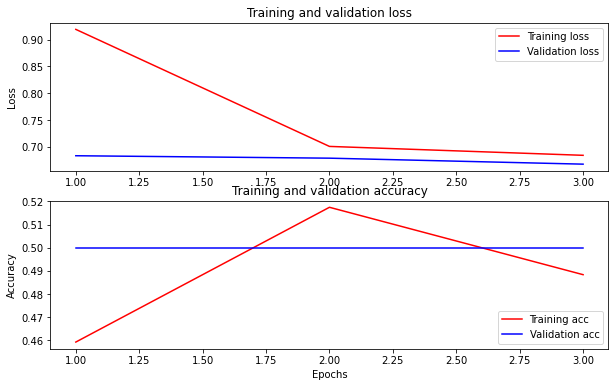

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
dataset_name = 'distilBert6'
saved_model_path = 'drive/My Drive/hollister_nlp/{}_bert'.format(dataset_name.replace('/', '_'))

In [ ]:
saved_model_path

'drive/My Drive/hollister_nlp/distilBert6_bert'

In [ ]:
#classifier_model.save(saved_model_path, include_optimizer=False)
#reloaded_model = tf.saved_model.load(saved_model_path)

KeyboardInterrupt: ignored

In [ ]:
reloaded_model = tf.saved_model.load('drive/My Drive/hollister_nlp/distilBert6_bert')

In [ ]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    '''Amazon kicks off inaugural digital health incubator cohort. For its first healthcare accelerator program, Amazon's cloud division tapped a diverse group of startups working in virtual reality, voice assistant technology, remote monitoring and social determinants of health.

Amazon Web Services (AWS) announced in June a healthcare accelerator to help incubate early-stage digital health companies that can collaborate with the tech giant's healthcare customers and partners.

The aim, Amazon said, is to connect growth-stage digital health solutions with AWS’ healthcare provider organizations to accelerate care in the cloud and for potential pilots and collaborations between providers and companies.'''
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
#original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
#print('Results from the model in memory:')
#print_my_examples(examples, original_results)

Results from the saved model:
input: Amazon kicks off inaugural digital health incubator cohort. For its first healthcare accelerator program, Amazon's cloud division tapped a diverse group of startups working in virtual reality, voice assistant technology, remote monitoring and social determinants of health.

Amazon Web Services (AWS) announced in June a healthcare accelerator to help incubate early-stage digital health companies that can collaborate with the tech giant's healthcare customers and partners.

The aim, Amazon said, is to connect growth-stage digital health solutions with AWS’ healthcare provider organizations to accelerate care in the cloud and for potential pilots and collaborations between providers and companies. : score: 0.991231



In [ ]:
ggg = pd.DataFrame()
ggg['input'] = np.array(examples)
ggg['predicted_score'] = np.array(reloaded_results)
ggg

,input,predicted_score
0,halo this is just a testing document. It should not score a very high opportunity with key word like environment,0.457255
1,Google is launching google class in the next half and it will potentially open up more markets on the vr side. This may also have some impact in environmental side as people might walk out more because of this,0.956329


In [ ]:
from flask import Flask, render_template
from flask_wtf import FlaskForm
from wtforms import StringField, SubmitField
from wtforms.validators import DataRequired
import tensorflow as tf
import numpy as np
import tensorflow_text as text

In [ ]:
from flask import Flask, render_template
import tensorflow as tf
import numpy as np
import tensorflow_text as text

app = Flask(__name__)
app.config['SECRET_KEY'] = 'any secret string'

distil_bert = tf.saved_model.load('drive/My Drive/hollister_nlp/distilBert6_bert')

class Input(FlaskForm):
    query = StringField('Query', validators=[DataRequired()])
    submit = SubmitField('Submit')

@app.route("/", methods=['POST', 'GET'])
@app.route("/index", methods=['POST', 'GET'])
def predict():
    form = Input()
    if form.validate_on_submit():
        query = form.query.data

        result = tf.sigmoid(distil_bert(tf.constant(query)))
        dic = {"Probability the clue will be used": str(result),
            "will the clue be used?": np.where(result > 0.5, 1, 0)
            }
        return dic
    else:
        return render_template('drive/My Drive/hollister_nlp/index.html', form=form)